In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim.lr_scheduler as lr_scheduler


ct = 0

np.random.seed(20)
random.seed(20)
torch.manual_seed(20)

flg = 0
dx = 20;
dy = 1
N = 100;
torch.set_printoptions(precision=10)
torch.set_default_tensor_type(torch.DoubleTensor)
X = torch.randn(dx,N);
X = torch.nn.functional.normalize(X,p=2,dim=0)     ### Input data

class sq_relu(nn.Module): 
    def __init__(self): 
        super(sq_relu, self).__init__() 

    def forward(self, x): 
        rl = torch.relu(x) 
        return rl

# Define the neural network 
class Net(nn.Module): 
    def __init__(self, H1,H2): 
        super(Net, self).__init__() 
        self.fc1 = nn.Linear(dx,H1,bias=False)
        self.fc2 = nn.Linear(H1,H2,bias=False)
        self.fc3 = nn.Linear(H2,dy,bias=False)
        self.activation = sq_relu()

    def forward(self, x): 
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x

### Defining Labels as the output of a smaller network
N_hid1_gt = 2
N_hid2_gt = 2
model_gt = Net(N_hid1_gt,N_hid1_gt)
init_u1_gt = torch.randn(dx,N_hid1_gt);
init_u2_gt = torch.abs(torch.randn(N_hid1_gt,N_hid2_gt));
init_u3_gt = torch.randn(N_hid2_gt,1);
nm_tot = torch.sqrt(torch.linalg.matrix_norm(init_u3_gt)**2+torch.linalg.matrix_norm(init_u2_gt)**2)
with torch.no_grad():
    model_gt.fc1.weight.data = init_u1_gt.clone().T
    model_gt.fc2.weight.data = init_u2_gt.clone().T
    model_gt.fc3.weight.data = init_u3_gt.clone().T

y = 10*model_gt(X.T);   ## Labels

N_hid1 = 20     #### Number of hidden neurons
N_hid2 = 30   

# Define the neural network 
    
import torch.optim.lr_scheduler as lr_scheduler

model = Net(N_hid1,N_hid2)

learning_rate = 0.0001
num_epochs = 200000
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=40000, gamma=0.05)
loss_fn = nn.MSELoss(reduction='sum')

init_u1 = torch.randn(dx,N_hid1);
init_u2 = torch.randn(N_hid1,N_hid2);
init_u3 = torch.randn(N_hid2,dy);
nm_tot = torch.sqrt(torch.linalg.matrix_norm(init_u1)**2 + torch.linalg.matrix_norm(init_u2)**2 + torch.linalg.matrix_norm(init_u3)**2)
init_u1 = init_u1/nm_tot
init_u2 = init_u2/nm_tot
init_u3 = init_u3/nm_tot
dlt = 0.01
with torch.no_grad():
    model.fc1.weight.data = dlt*init_u1.clone().T      ##### Small initialization of weights
    model.fc2.weight.data = dlt*init_u2.clone().T
    model.fc3.weight.data = dlt*init_u3.clone().T

epochs = 0
nm_st = torch.zeros(num_epochs,1)
ls_st = torch.zeros(num_epochs,1)
dc_st = torch.zeros(num_epochs,1)
U1_st = torch.zeros(N_hid1,dx,num_epochs)
U2_st = torch.zeros(N_hid2,N_hid1,num_epochs)
U3_st = torch.zeros(dy,N_hid2,num_epochs)
flg = 0
pred = model(X.T);
loss = loss_fn(pred,y)
lo = loss.item()
ct = 0

while epochs < num_epochs:
#     ###### Storing loss
    ls_st[epochs] = loss.item()

    # Backpropagation
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    ##### Storing the weights
    U1 = model.fc1.weight.data.detach()
    U2 = model.fc2.weight.data.detach()
    U3 = model.fc3.weight.data.detach()
    U1_st[:,:,epochs] = U1
    U2_st[:,:,epochs] = U2
    U3_st[:,:,epochs] = U3

    pred = model(X.T);
    loss = loss_fn(pred,y)

    if epochs%20000==0:
        print(loss.item())     ##### Printing loss after every 10000 epochs

    epochs = epochs+1


191.1111398182573
191.11113978011582
191.11113972691788
191.11113964184293
191.11113948900726
191.11113917475893
191.11113839269552
191.11113567639688
191.11111804967635
191.10982006192077


Text(185510, 30, '(II)')

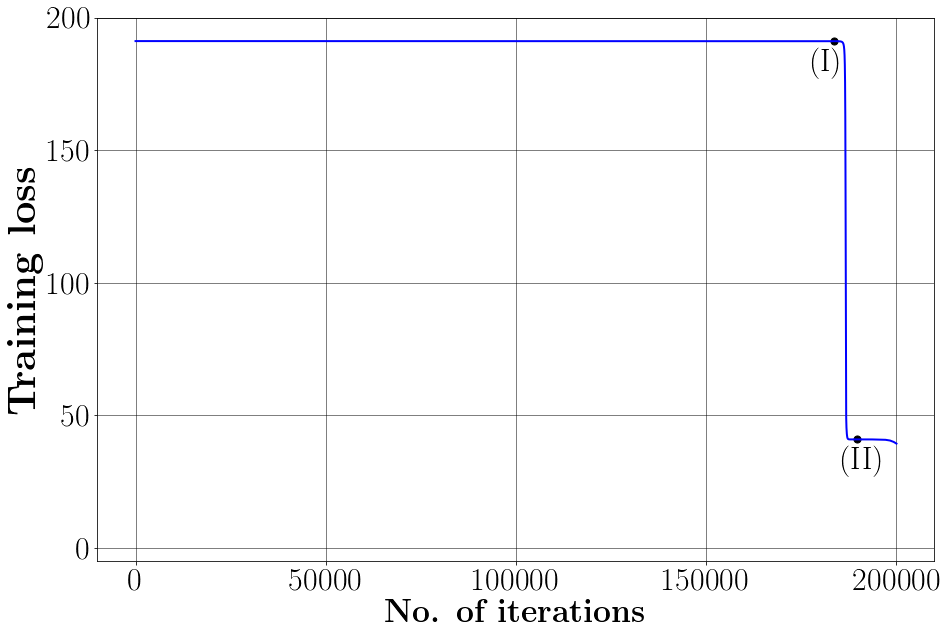

In [4]:
###### Plot of the evolution of loss with iterations

import math as m
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['text.usetex']=True
# plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'
# plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 32}
matplotlib.rc('font', **font)
st_itr = 0
end_itr = 200000
stp = 10
ep1 = 183510
ep2 = 189510

fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel(r'\textbf{No. of iterations}')
ax.plot(np.arange(st_itr,end_itr),ls_st[st_itr:end_itr],color='b', linestyle='-',linewidth = 2)
ax.set_ylabel(r'\textbf{Training loss}',rotation='vertical',fontsize=40)
ax.grid(b=True, which='major', color='k', linestyle='-',linewidth = 0.5)
ax.scatter(ep1,ls_st[ep1],50,'k')
ax.scatter(ep2,ls_st[ep2],50,'k')
ax.set_ylim([-5,200])

W, H = ep1, 180
ax.text(W-6000, H, r'(I)')
W, H = ep2, 30
ax.text(W-4000, H, r'(II)')


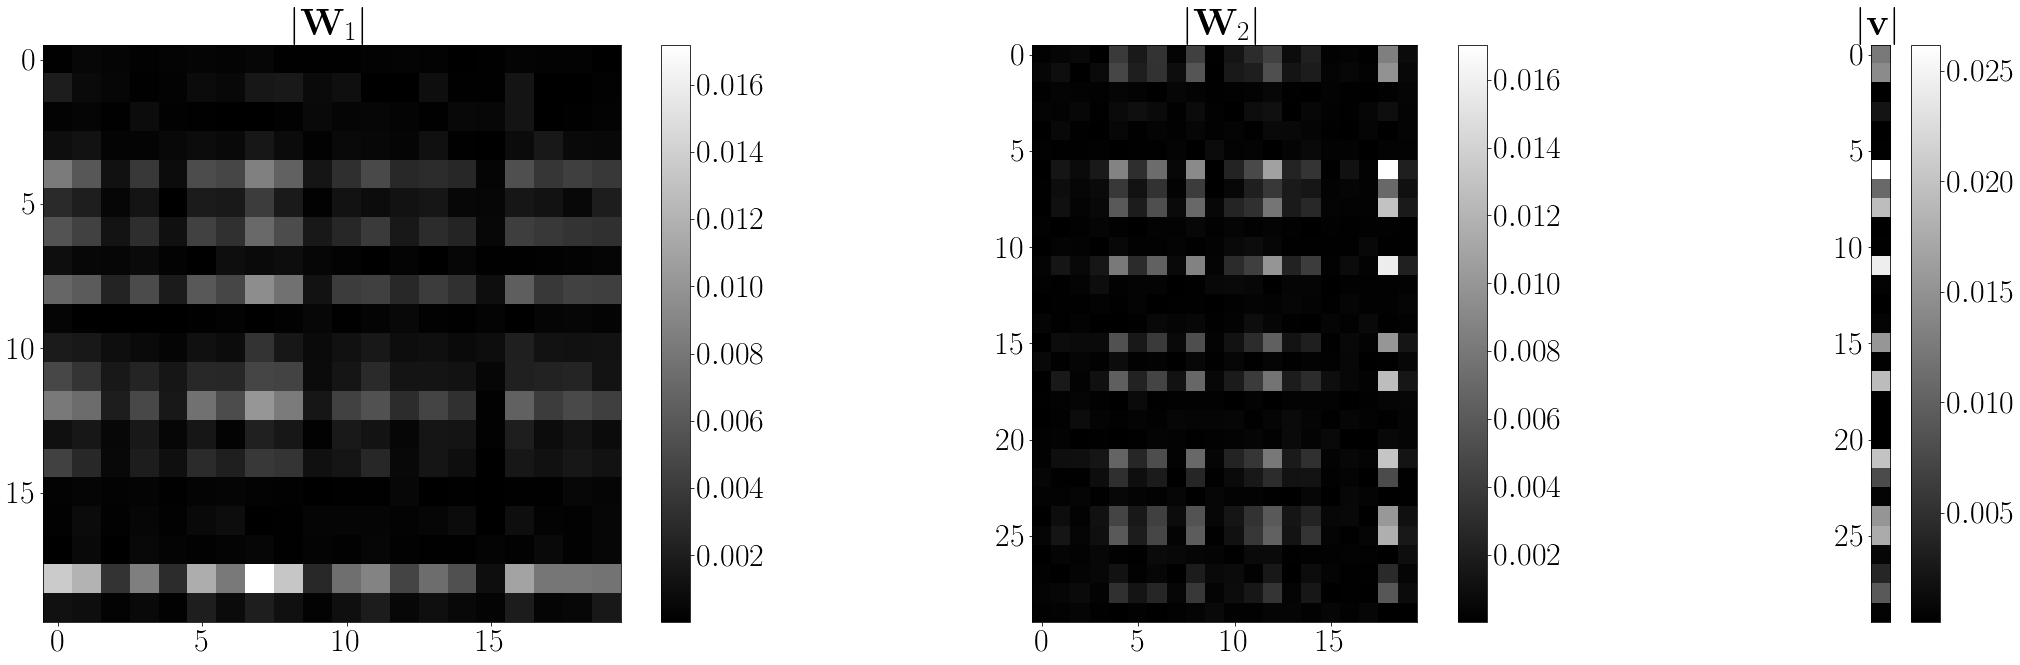

In [5]:
### Plotting weights at iteration 183510, just before escaping the origin

yticks1 = np.arange(0, 20, 5)  # Example: Show y-ticks at intervals of 2
yticks2 = np.arange(0, 30, 5)

fig = plt.figure(figsize=(30, 10))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 2, 1])  # First subplot twice as wide as second

# Plot the first image
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(torch.abs(U1_st[:, :, 183510]), cmap='gray')
ax1.set_title(r'$|\mathbf{W}_1|$')
ax1.set_yticks(yticks1)
fig.colorbar(im1, ax=ax1)

# Plot the second image
ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(torch.abs(U2_st[:, :, 183510]), cmap='gray')
ax2.set_title(r'$|\mathbf{W}_2|$')
ax2.set_yticks(yticks2)
fig.colorbar(im2, ax=ax2)

# Plot the third image
ax3 = fig.add_subplot(gs[2])
im3 = ax3.imshow(torch.abs(U3_st[:, :, 183510].T), cmap='gray')
ax3.set_title(r'$|\mathbf{v}|$')
ax3.set_xticks([])  # Remove x-axis ticks for the second plot
ax3.set_yticks(yticks2)
fig.colorbar(im3, ax=ax3)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()

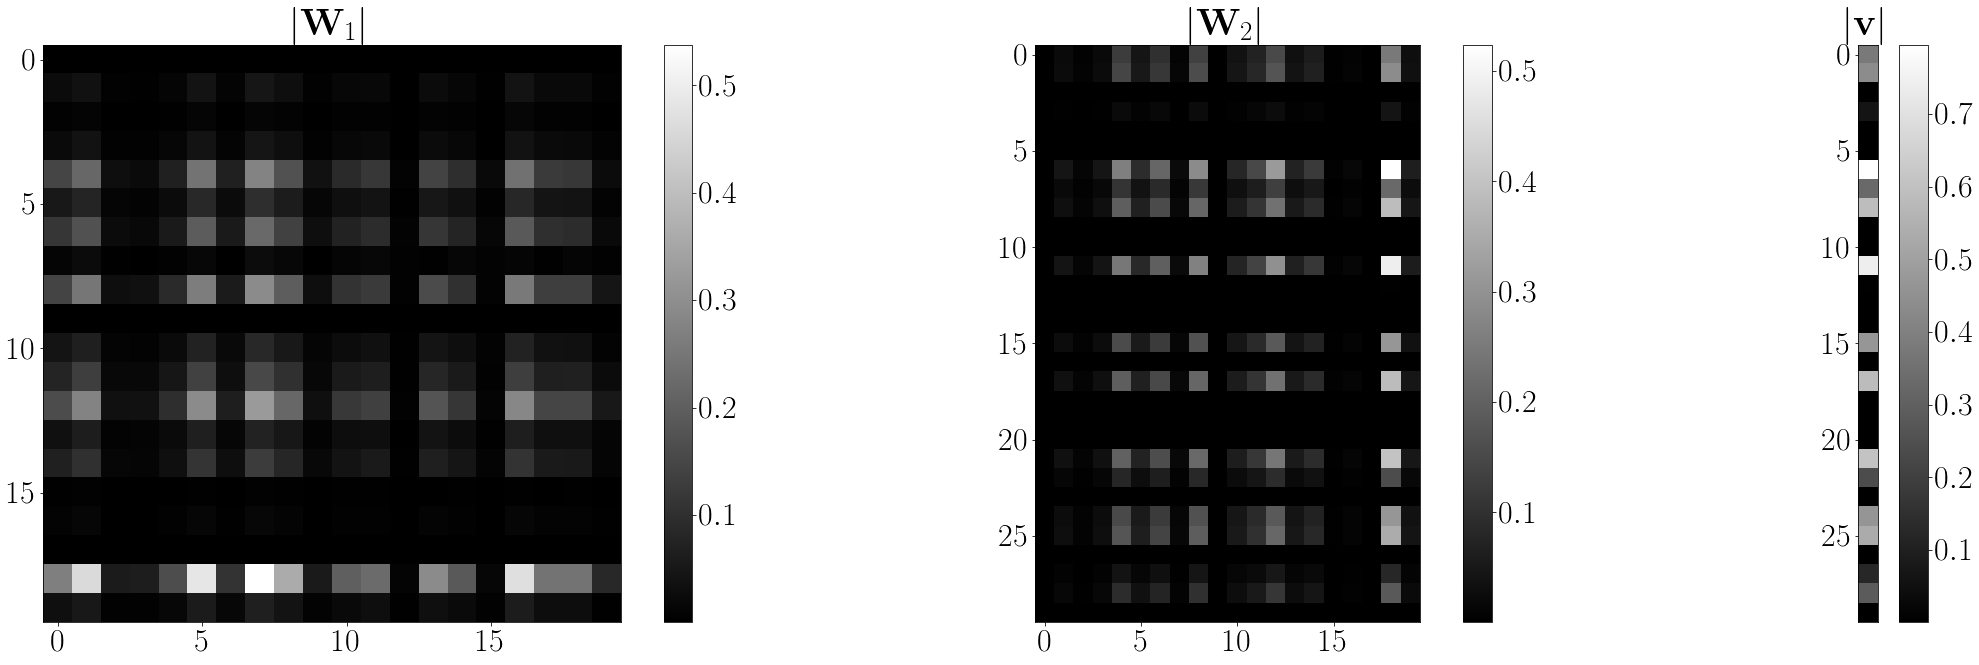

In [6]:
### Plotting weights at iteration 189510, just after reaching the saddle point


yticks1 = np.arange(0, 20, 5)  # Example: Show y-ticks at intervals of 2
yticks2 = np.arange(0, 30, 5)

fig = plt.figure(figsize=(30, 10))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 2, 1])  # First subplot twice as wide as second

# Plot the first image
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(torch.abs(U1_st[:, :, 189510]), cmap='gray')
ax1.set_title(r'$|\mathbf{W}_1|$')
ax1.set_yticks(yticks1)
fig.colorbar(im1, ax=ax1)

# Plot the second image
ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(torch.abs(U2_st[:, :, 189510]), cmap='gray')
ax2.set_title(r'$|\mathbf{W}_2|$')
ax2.set_yticks(yticks2)
fig.colorbar(im2, ax=ax2)

# Plot the third image
ax3 = fig.add_subplot(gs[2])
im3 = ax3.imshow(torch.abs(U3_st[:, :, 189510].T), cmap='gray')
ax3.set_title(r'$|\mathbf{v}|$')
ax3.set_xticks([])  # Remove x-axis ticks for the second plot
ax3.set_yticks(yticks2)
fig.colorbar(im3, ax=ax3)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()